In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
os.chdir("../") # Going one folder above

In [2]:
import portfolio_methods
import portfolio_optimizer as po
import json
import sys
import datetime as dt
import numpy as np
from portfolio import Portfolio, PM, StrategyPortfolio
import universe
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from seaborn import distplot
font = {'size'   : 15}
matplotlib.rc('font', **font)
matplotlib.style.use('bmh')
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

In [3]:
tickers = json.load(open("jsons/tutorial_portfolio.json","r")) # Try changing for tutorial_etfs to see the change
tickers = PM._flatDict(tickers)

# Equaly weighted portfolio
allocation = np.ones(len(tickers))
allocation /= allocation.sum()

# LONG ON FIRST ONES, SHORT ON LAST
direction = [1 for i in range(len(allocation))]
direction[-1] = -1
direction = np.array(direction)

In [4]:
# Make portfolio
pi = Portfolio(tickers, allocation, direction, ("RISK_FREE", "USA"), firstPriceOpen=False)
pi.setCAPMFactors([('TIME_SERIES_DAILY_ADJUSTED', 'IWV')]) # Accept more factors for multi-factor model, just add another tuple
# One interesting thing is to download the fama factors from his website, transform into parquet timeseries and use here
# Please be aware with the data frequency (I believe they provide monthly returns)
pi.setDateRange('2017-1-1', '2019-11-22')
pi.setFrequency('1D') # Try 7D, 15D, 1M etc
pi.make()

Loading size:  5
Loading size:  1
[Allocated value]:  1.0
Loading size:  1
Finished 'make' in 2.5295 secs


//anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


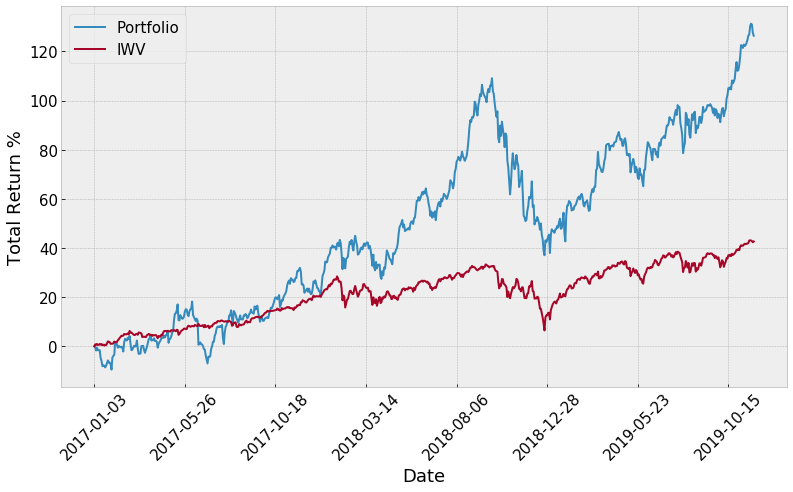

In [5]:
rets = pi.plot()

In [6]:
summ = pi.summarize()


[PORTFOLIO SUMMARY]
[FROM]:  2017-01-01
[TO]:  2019-11-22

Sharpe ratio:  1.1321670891213493
Alpha:  [0.14780865]
Beta:  [[1.33989461]]
Expected:  0.3199087204411626
Annualized return:  0.3273718925055471
Vol:  0.27285062028531964
Vol Idio:  0.21044212451673688
Total Return:  1.2637333869934082
Information Ratio:  13.918145232670906
Vol ('TIME_SERIES_DAILY_ADJUSTED', 'IWV'):  0.12948096765942546
Sharpe ('TIME_SERIES_DAILY_ADJUSTED', 'IWV'):  0.9280340829034421
Cumreturn factors:              (TIME_SERIES_DAILY_ADJUSTED, IWV)
2019-11-22                           0.426776
Max 1y DD:  -0.34445924257757377
Avg last 5 1y DD:  -0.33131785800823843



In [7]:
# To get the contribution of each asset in the total return by the end of the period
# With this you can make a barplot of contributions (weighted returns)
((1+pi.contributions).cumprod().tail(1).T-1)

,2019-11-22 00:00:00
"(TIME_SERIES_DAILY_ADJUSTED, AAPL)",0.271925
"(TIME_SERIES_DAILY_ADJUSTED, GOOG)",0.129543
"(TIME_SERIES_DAILY_ADJUSTED, AMD)",0.485035
"(TIME_SERIES_DAILY_ADJUSTED, NVDA)",0.217547
"(TIME_SERIES_DAILY_ADJUSTED, CLVS)",0.159673


In [8]:
# Asserting it matches the end of the timeseries
pi.pReturn['cumreturn'].tail(1) - 1

2019-11-22    1.263733
Name: cumreturn, dtype: float32

In [9]:
# The sum of contributions
((1+pi.contributions).cumprod().tail(1).T-1).sum()

2019-11-22    1.263723
dtype: float32

In [10]:
# To get the cumulative return of each asset in the total return by the end of the period
# This is UNWEIGHTED and does not take into account your direction (long/short)
((1+pi.data['assetsReturn']).cumprod().tail(1).T-1)

,2019-11-22 00:00:00
"(TIME_SERIES_DAILY_ADJUSTED, AAPL)",1.359617
"(TIME_SERIES_DAILY_ADJUSTED, GOOG)",0.647721
"(TIME_SERIES_DAILY_ADJUSTED, AMD)",2.425195
"(TIME_SERIES_DAILY_ADJUSTED, NVDA)",1.087725
"(TIME_SERIES_DAILY_ADJUSTED, CLVS)",-0.798370


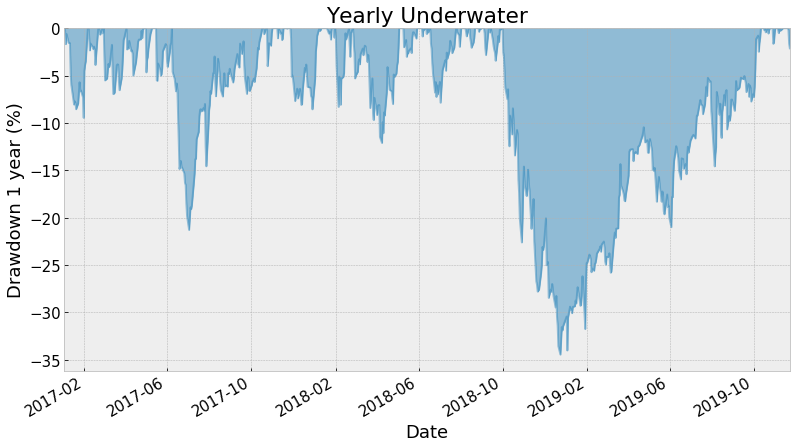

In [11]:
pi.plotUnderwater()

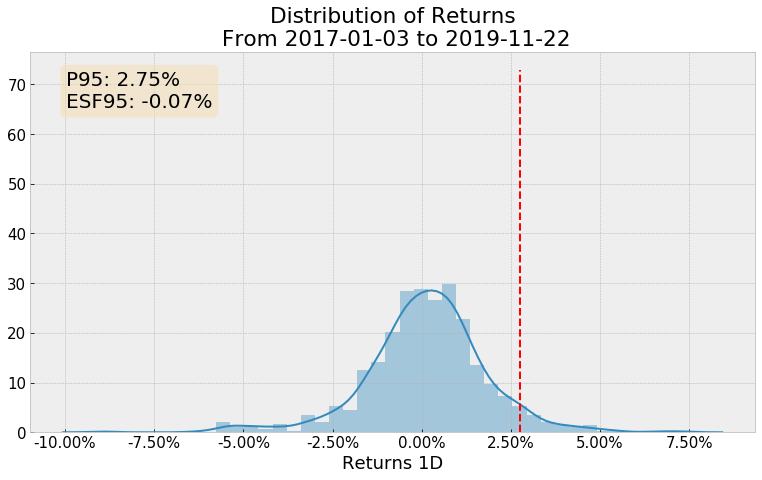

In [12]:
pi.plotVAR(95) # For daily returns, take same portfolio frequency

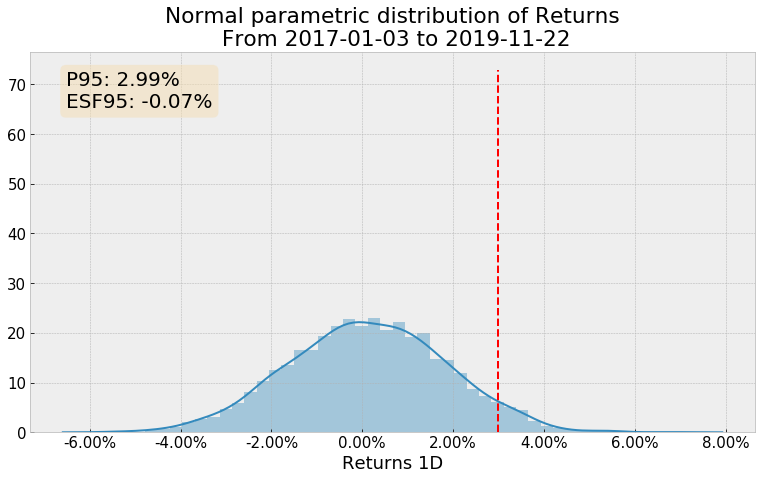

In [13]:
pi.plotParametricVAR(95) # For daily returns, take same portfolio frequency

In [14]:
# Top 10 drawdowns 22 * data frequency (in this case, monthly)
# The date in the index is the date of the lowest point
pi.drawdown(22, top=10)

2018-10-29   -0.226082
2017-07-03   -0.212930
2018-10-30   -0.203704
2018-10-26   -0.200769
2017-06-30   -0.198200
2017-07-06   -0.190987
2017-07-05   -0.189180
2017-07-07   -0.187116
2018-11-21   -0.186757
2017-06-29   -0.185026
Name: dd, dtype: float64

In [15]:
# Data can be found inside
pi.data.keys()

dict_keys(['price', 'priceOnFreq', 'assetsReturn', 'assetsReturnOnFreq', 'rfDaily', 'rfOnFreq', 'factorsReturn', 'factorsReturnOnFreq'])

In [16]:
pi.data['rfDaily'].head()

,"(4 WEEKS, COUPON EQUIVALENT)"
2017-01-03,0.000014
2017-01-04,0.000014
2017-01-05,0.000014
2017-01-06,0.000014
2017-01-09,0.000014


In [17]:
pi.data['priceOnFreq'].head()

,"(TIME_SERIES_DAILY_ADJUSTED, AAPL)","(TIME_SERIES_DAILY_ADJUSTED, GOOG)","(TIME_SERIES_DAILY_ADJUSTED, AMD)","(TIME_SERIES_DAILY_ADJUSTED, NVDA)","(TIME_SERIES_DAILY_ADJUSTED, CLVS)","(TIME_SERIES_DAILY_ADJUSTED, IWV)"
2017-01-03,110.941803,786.140015,11.43,100.940300,42.950001,126.970497
2017-01-04,110.817596,786.900024,11.43,103.295403,44.669998,127.984901
2017-01-05,111.381203,794.020020,11.24,100.673203,46.330002,127.747902
2017-01-06,112.622902,806.150024,11.32,102.018898,46.029999,128.212402
2017-01-09,113.654503,806.650024,11.49,106.155098,50.860001,127.700500


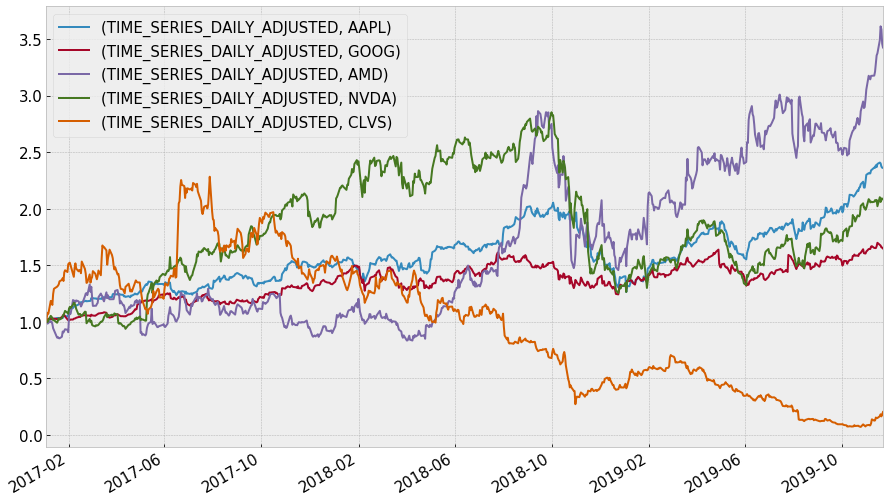

In [20]:
# All timeseries plot
(1+pi.data['assetsReturnOnFreq']).cumprod().plot(figsize=(15,9))